In [2]:
print("hello world")

hello world


In [3]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor,ToPILImage, Normalize, Resize, CenterCrop, RandomResizedCrop
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torch.hub import load_state_dict_from_url
from stepbystep.v3 import StepByStep

2024-03-14 22:51:12.630404: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 22:51:12.879650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 22:51:12.879706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 22:51:12.893617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 22:51:12.933179: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 22:51:12.934042: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Pre-Trained Model

In [4]:
alex = alexnet(weights=None)
print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
from torchinfo import summary
summary(alex,input_size=(16,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [16, 1000]                --
├─Sequential: 1-1                        [16, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [16, 64, 55, 55]          23,296
│    └─ReLU: 2-2                         [16, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [16, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [16, 192, 27, 27]         307,392
│    └─ReLU: 2-5                         [16, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [16, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [16, 384, 13, 13]         663,936
│    └─ReLU: 2-8                         [16, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [16, 256, 13, 13]         884,992
│    └─ReLU: 2-10                        [16, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [16, 256, 13, 13]        

### Average Pooling  
Returns the tensor with desired shape regardless of the input shape

In [6]:
result1=F.adaptive_avg_pool2d(input=torch.randn(16,32,32),output_size=(6,6))
result2=F.adaptive_avg_pool2d(input=torch.randn(16,32,32),output_size=(6,6))
result1.shape,result2.shape

(torch.Size([16, 6, 6]), torch.Size([16, 6, 6]))

### Loading Weights

In [7]:
# URL for alexnet pretrained weights


In [8]:
from torchvision.models import AlexNet_Weights
alex=alexnet(weights=AlexNet_Weights.DEFAULT)

In [9]:
print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# Model freezing
def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad=False

In [11]:
freeze_model(alex)

### Top of the model

In [12]:
alex.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [13]:
#replacing the top of the model
alex.classifier[6]=nn.Linear(4096,3)

In [14]:
# Check for gradient calculation requirement of output layer
for name,param in alex.named_parameters():
    if param.requires_grad==True:
        print(name)

classifier.6.weight
classifier.6.bias


In [15]:
summary(alex,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           (23,296)
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          (307,392)
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          (663,936)
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          (884,992)
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13] 

In [16]:
# Model config
torch.manual_seed(17)
multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
optimizer_alex=optim.Adam(alex.parameters(),lr=3e-4)

In [17]:
# Data prep
normalizer=Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
composer=Compose(transforms=[Resize(256),CenterCrop(224),ToTensor(),normalizer])

train_data=ImageFolder(root='rps',transform=composer)
val_data=ImageFolder(root='rps-test-set',transform=composer)

train_loader=DataLoader(dataset=train_data,batch_size=16,shuffle=True)
val_loader=DataLoader(dataset=val_data,batch_size=16)

In [18]:
# Model Training
sbs_alex=StepByStep(alex,multi_loss_fn,optimizer_alex)
sbs_alex.set_loaders(train_loader,val_loader)
sbs_alex.train(3)

  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
StepByStep.loader_apply(val_loader,sbs_alex.correct)

tensor([[110, 124],
        [124, 124],
        [124, 124]])

In [20]:
StepByStep.loader_apply(train_loader,sbs_alex.correct)

tensor([[838, 840],
        [839, 840],
        [840, 840]])

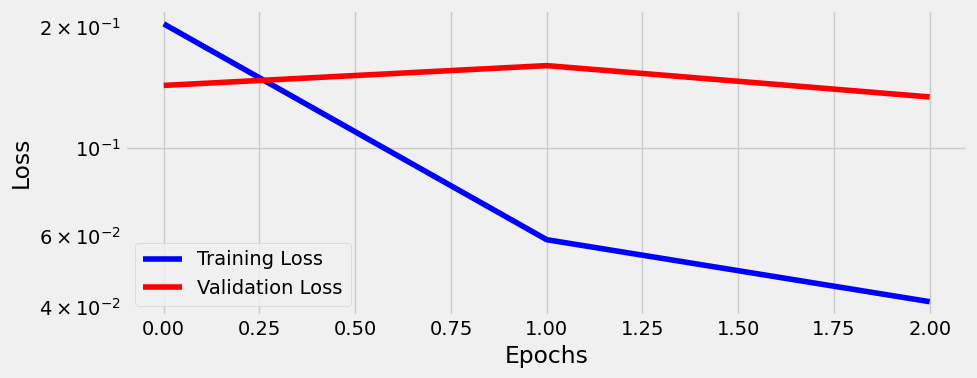

In [21]:
sbs_alex.plot_losses()

## Generating a Dataset of features

In [23]:
# Removing the Top layer
alex.classifier[6]=nn.Identity()
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Identity()
)


In [30]:
from tqdm.notebook import tqdm

def preprocessed_dataset(model,loader,device=None):
    if device is None:
        device=next(model.parameters()).device
    features=None
    labels=None

    for i,(x,y) in tqdm(enumerate(loader)):
        model.eval()
        output=model(x.to(device))

        if i==0:
            features=output.detach().cpu()
            labels=y.cpu()

        else:
            features=torch.cat([features,output.detach().cpu()])
            labels=torch.cat([labels,y.cpu()])

    dataset=TensorDataset(features,labels)
    return dataset

In [31]:
# Data preparation
train_preproc=preprocessed_dataset(alex,train_loader)
val_preproc=preprocessed_dataset(alex,val_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [44]:
!pwd

/home/anushka/Documents/Deep-Learning/Deep Learning with Pytorch


Save pre processed dataset

In [45]:
torch.save(train_preproc.tensors,'rps_preproc.pth')
torch.save(val_preproc.tensors,'rps_val_preproc.pth')

## Auxilary Classifiers (Side Heads)  
Side heads attached to intermediate parts of the model try to perform callsification independently from main classifier. 

In [57]:
# Loading pretrained inceptionv3 and replacing top layers
from torchvision.models import Inception_V3_Weights
model=inception_v3(weights=Inception_V3_Weights)
freeze_model(model)

torch.manual_seed(42)
model.AuxLogits.fc=nn.Linear(768,3)
model.fc=nn.Linear(2048,3)

/home/anushka/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/anushka/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [04:52<00:00, 373kB/s] 


In [61]:
summary(model,input_size=(16,3,299,299))

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [16, 3]                   2,560,003
├─BasicConv2d: 1-1                       [16, 32, 149, 149]        --
│    └─Conv2d: 2-1                       [16, 32, 149, 149]        (864)
│    └─BatchNorm2d: 2-2                  [16, 32, 149, 149]        (64)
├─BasicConv2d: 1-2                       [16, 32, 147, 147]        --
│    └─Conv2d: 2-3                       [16, 32, 147, 147]        (9,216)
│    └─BatchNorm2d: 2-4                  [16, 32, 147, 147]        (64)
├─BasicConv2d: 1-3                       [16, 64, 147, 147]        --
│    └─Conv2d: 2-5                       [16, 64, 147, 147]        (18,432)
│    └─BatchNorm2d: 2-6                  [16, 64, 147, 147]        (128)
├─MaxPool2d: 1-4                         [16, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [16, 80, 73, 73]          --
│    └─Conv2d: 2-7                       [16, 80, 73, 73]

In [62]:
def inception_loss(outputs,labels):
    try:
        main,aux=outputs
    except ValueError:
        main=outputs
        aux=None
        loss_aux=0
    
    multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
    loss_main=multi_loss_fn(main,labels)

    if aux is not None:
        loss_aux=multi_loss_fn(aux,labels)
    return loss_main+0.4*loss_aux

In [63]:
# model config
optimizer_model=optim.Adam(model.parameters(),lr=3e-4)
sbs_incep=StepByStep(model,inception_loss,optimizer_model)

We do not pre processed the dataset since preprocessed_dataset() cannot handle multiple outputs

In [67]:
# Data prep
normalizer=Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
composer=Compose(transforms=[Resize(299),ToTensor(),normalizer])

train_data=ImageFolder(root='rps',transform=composer)
val_data=ImageFolder(root='rps-test-set',transform=composer)

train_loader=DataLoader(dataset=train_data,batch_size=16,shuffle=True)
val_loader=DataLoader(dataset=val_data,batch_size=16)

In [68]:
# Model Training
sbs_incep.set_loaders(train_loader,val_loader)
sbs_incep.train(5)

  0%|          | 0/5 [00:00<?, ?it/s]